In [20]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string

import scipy
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
from tqdm import tqdm
tqdm.pandas()

In [22]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [23]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [24]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http",
              "https","char","reuters","wall","street","journal","photo"]

In [25]:
domain_extensions = ['.com/','.org/','.net/','.co.uk/']

def url_subpages(url):
    for extension in domain_extensions:
        if extension in url:
            m = re.search(extension,url)
            start_pos = m.start()+5
            return url[start_pos:]
        else:
            pass


In [26]:
def black_txt(token):
    return  token not in stopwords and token not in list(string.punctuation)  and len(token)>3

def clean_txt(text, string = True):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text = re.sub("\n", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    if string == True:
        return " ".join(clean_text2)
    else:
        return clean_text2

# Read and Clean

In [7]:
#load in data
data = pd.read_csv('initial_data.csv', index_col = 0)
data.reset_index(drop=True, inplace=True)
data = data.drop_duplicates('url', keep = 'first')
data.drop(['urlToImage'],axis=1,inplace=True)

In [8]:
conditions = [
    (data['content'].isna())
]

choices = [
    (data['description'])
]

data['content'] = np.select(conditions, choices, data['content'])

In [9]:
#drop where description is isna()
to_drop = data[data['description'].isna()].index
data.drop(to_drop, inplace=True)

#drop where title is isna()
to_drop = data[data['title'].isna()].index
data.drop(to_drop, inplace=True)

#drop where target is isna()
to_drop = data[data['target'].isna()].index
data.drop(to_drop, inplace=True)

#drop where publishedAt is isna()
to_drop = data[data['publishedAt'].isna()].index
data.drop(to_drop, inplace=True)

#drop where month is isna()
to_drop = data[data['month'].isna()].index
data.drop(to_drop, inplace=True)

#drop where content is isna()
to_drop = data[data['content'].isna()].index
data.drop(to_drop, inplace=True)

#drop where url is isna()
to_drop = data[data['url'].isna()].index
data.drop(to_drop, inplace=True)

In [10]:
conditions = [
    (data['author'].isna())
]

choices = [
    ('unknown')
]

data['author'] = np.select(conditions, choices, data['author'])

In [11]:
data.drop(['description'],axis=1,inplace=True)

In [12]:
data=data.dropna()

In [13]:
data.isna().sum()

source         0
author         0
title          0
url            0
publishedAt    0
content        0
target         0
month          0
full_text      0
dtype: int64

In [14]:
data['url_subpages'] = data['url'].apply(url_subpages)

In [15]:
data.head()

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages
0,abc-news,"Mina Kaji, Amanda Maile",COVID-19 risk on planes 'very low' with proper...,https://abcnews.go.com/Politics/covid-19-risk-...,2020-10-27 18:39:39+00:00,The risk of COVID-19 transmission onboard a pl...,left,10.0,COVID-19 risk on planes 'very low' with proper...,Politics/covid-19-risk-planes-low-proper-measu...
1,abc-news,Kelly Cannon,Election officials scrambling to address coron...,https://abcnews.go.com/Politics/election-offic...,2020-03-01 09:33:45+00:00,With fears of the novel coronavirus spreading ...,left,3.0,Some election officials scrambling to address ...,Politics/election-officials-scrambling-address...
2,abc-news,Julia Jacobo,Global death toll of coronavirus reaches nearl...,https://abcnews.go.com/US/global-death-toll-co...,2020-03-01 15:08:53+00:00,The global death toll of coronavirus has reach...,left,3.0,Authorities report 2nd coronavirus death in U....,US/global-death-toll-coronavirus-reaches-3000-...
3,abc-news,The Associated Press,Can I get the coronavirus twice?,https://abcnews.go.com/Lifestyle/wireStory/cor...,2020-09-03 13:35:12+00:00,Can I get the coronavirus twice?\r\nIt seems p...,left,9.0,Can I get the coronavirus twice? Can I get the...,Lifestyle/wireStory/coronavirus--72789225
4,abc-news,ABC News,WATCH: Pence and Harris address coronavirus re...,https://abcnews.go.com/Politics/video/pence-ha...,2020-10-08 03:18:22+00:00,<li>Now Playing: What to watch for during the ...,left,10.0,Transcript for Pence and Harris address corona...,Politics/video/pence-harris-address-coronaviru...


In [16]:
data['predictor'] = data['title'] + ' ' + data['full_text']

# Feature Engineering

In [17]:
blob = TextBlob((data.predictor[1]))

In [18]:
import textacy

def get_basic_stat(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    basic_stats = {'n_chars': ts.n_chars,
                   'n_long_words':ts.n_long_words ,
                   'n_monosyllable_words': ts.n_monosyllable_words,
                   'n_polysyllable_words': ts.n_polysyllable_words,
                   'n_sents': ts.n_sents,
                   'n_syllables': ts.n_syllables,
                   'n_unique_words': ts.n_unique_words,
                   'n_words': ts.n_words}
    return  basic_stats

In [ ]:
tqdm.pandas()
data['Stats'] = data['predictor'].progress_apply(get_basic_stat)

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  2%|▏         | 261/15133 [00:37<1:10:21,  3.52it/s]

In [ ]:
data['n_long_words'] = data['Stats'].apply(lambda x: x['n_long_words'] / x['n_words'])

data['n_monosyllable_words'] = data['Stats'].apply(lambda x: x['n_monosyllable_words'] / x['n_words'])

data['n_polysyllable_words'] = data['Stats'].apply(lambda x: x['n_polysyllable_words'] / x['n_words'])

data['n_unique_words'] = data['Stats'].apply(lambda x: x['n_unique_words'] / x['n_words'])

**Textblob and sentiment**

In [ ]:
def polarity_txt(text):
    return TextBlob(text).sentiment[0]

In [ ]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

In [ ]:
data['polarity'] = data['predictor'].apply(polarity_txt)
data.head(2)

In [ ]:
data['subjectivity'] = data['predictor'].progress_apply(subj_txt)
data.head(2)

In [ ]:
data.target.value_counts()

In [ ]:
from sklearn.utils import resample
right = data[data.target == 'right']
center = data[data.target == 'center']
left = data[data.target =='left']

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in minority class
                          random_state=42) 

center_upsampled = resample(center,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in minority class
                          random_state=42) 

data = pd.concat([left, right_upsampled, center_upsampled])
data.target.value_counts()

In [ ]:
data.reset_index(drop=True,inplace=True)

In [ ]:
data.head()

In [27]:
data = pd.read_csv('clean_data.csv',index_col=0)

# Test out LDA

In [28]:
import gensim

In [29]:
lda_right = data[data['target']=='right']['predictor']
lda_center = data[data['target']=='right']['predictor']
lda_left = data[data['target']=='right']['predictor']
all_sides = data['predictor']

In [30]:
lda_right_token = lda_right.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_right_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_right_token]

right_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

right_lda.show_topics(formatted=False)

100%|██████████| 5934/5934 [00:26<00:00, 221.42it/s]


[(0,
  [('coronavirus', 0.016075337),
   ('trump', 0.011107541),
   ('test', 0.009354365),
   ('state', 0.009177731),
   ('president', 0.00811495),
   ('case', 0.006906537),
   ('covid', 0.006434177),
   ('people', 0.006128381),
   ('health', 0.0052955444),
   ('virus', 0.0050346954)]),
 (1,
  [('coronavirus', 0.010567954),
   ('china', 0.009266404),
   ('people', 0.006301621),
   ('world', 0.0055761198),
   ('chinese', 0.0047732517),
   ('time', 0.0044867718),
   ('state', 0.0044324365),
   ('virus', 0.003888116),
   ('government', 0.0038870587),
   ('would', 0.0037131347)]),
 (2,
  [('coronavirus', 0.010945339),
   ('state', 0.0050665983),
   ('people', 0.0047337497),
   ('would', 0.0045280624),
   ('time', 0.004076709),
   ('news', 0.0040689004),
   ('pandemic', 0.0040178443),
   ('make', 0.0037225725),
   ('need', 0.0037028627),
   ('also', 0.0036530371)])]

In [31]:
lda_center_token = lda_center.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_center_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_center_token]

center_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

center_lda.show_topics(formatted=False)

100%|██████████| 5934/5934 [00:25<00:00, 235.93it/s]


[(0,
  [('coronavirus', 0.0140493605),
   ('state', 0.011650425),
   ('china', 0.009502081),
   ('case', 0.0075843297),
   ('people', 0.0060756747),
   ('report', 0.005400836),
   ('chinese', 0.0050120545),
   ('virus', 0.0049085496),
   ('health', 0.0047721732),
   ('time', 0.0043817684)]),
 (1,
  [('trump', 0.011850295),
   ('coronavirus', 0.010288141),
   ('president', 0.008712084),
   ('people', 0.0058291224),
   ('would', 0.004867713),
   ('make', 0.004739091),
   ('house', 0.0045070276),
   ('time', 0.0042835097),
   ('test', 0.004100419),
   ('biden', 0.0035951769)]),
 (2,
  [('coronavirus', 0.01438987),
   ('covid', 0.006722182),
   ('health', 0.005878328),
   ('people', 0.0054980656),
   ('virus', 0.0050171018),
   ('test', 0.004520505),
   ('state', 0.0044633155),
   ('report', 0.004374638),
   ('time', 0.004360511),
   ('study', 0.004024204)])]

In [32]:
lda_left_token = lda_left.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_left_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_left_token]

left_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

left_lda.show_topics(formatted=False)

100%|██████████| 5934/5934 [00:24<00:00, 239.93it/s]


[(0,
  [('trump', 0.014580315),
   ('coronavirus', 0.010499212),
   ('president', 0.01032953),
   ('china', 0.0077651637),
   ('would', 0.0061943647),
   ('state', 0.0058674887),
   ('house', 0.0050359424),
   ('make', 0.004410059),
   ('people', 0.004273461),
   ('time', 0.0041781804)]),
 (1,
  [('coronavirus', 0.02095972),
   ('test', 0.010029532),
   ('covid', 0.0091168685),
   ('state', 0.008606779),
   ('case', 0.008572895),
   ('health', 0.007838024),
   ('virus', 0.007483327),
   ('report', 0.007392208),
   ('people', 0.0065649888),
   ('news', 0.0053438186)]),
 (2,
  [('people', 0.0068878415),
   ('coronavirus', 0.005804764),
   ('time', 0.005081956),
   ('state', 0.0043749996),
   ('make', 0.0037418331),
   ('pandemic', 0.0036778285),
   ('even', 0.0035145453),
   ('work', 0.0033789608),
   ('would', 0.00335014),
   ('government', 0.0032408712)])]

In [64]:
all_token = all_sides.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(all_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in all_token]

all_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

all_lda.show_topics(formatted=False)

100%|██████████| 17802/17802 [01:35<00:00, 186.60it/s]


[(0,
  [('coronavirus', 0.011721063),
   ('people', 0.008937441),
   ('home', 0.008285947),
   ('state', 0.0071894387),
   ('city', 0.0061911023),
   ('york', 0.005798146),
   ('health', 0.005501243),
   ('covid', 0.0052695503),
   ('order', 0.004942189),
   ('also', 0.0040837983)]),
 (1,
  [('state', 0.01181021),
   ('coronavirus', 0.008582594),
   ('vote', 0.008458441),
   ('would', 0.0068169073),
   ('bill', 0.005863492),
   ('election', 0.0049501727),
   ('house', 0.0048220144),
   ('fund', 0.004584795),
   ('senate', 0.0044122934),
   ('game', 0.0043874485)]),
 (2,
  [('china', 0.01698043),
   ('coronavirus', 0.010800861),
   ('chinese', 0.008479593),
   ('world', 0.007025274),
   ('state', 0.0063760807),
   ('government', 0.0060783685),
   ('virus', 0.0052364143),
   ('pandemic', 0.004389264),
   ('president', 0.0043842862),
   ('would', 0.004146555)]),
 (3,
  [('people', 0.0069202287),
   ('like', 0.00596554),
   ('coronavirus', 0.0056887004),
   ('pandemic', 0.005572301),
   ('

In [65]:
dominant_topics = []

for i in data.index:
    row_list = all_lda[bow_corpus][i]
    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    topic = row[0][0]
    dominant_topics.append(topic)
    

In [66]:
data['dominant_topic'] = pd.Series(dominant_topics)

In [67]:
data.head()

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,Stats,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity,dominant_topic
0,abc-news,"Mina Kaji, Amanda Maile",COVID-19 risk on planes 'very low' with proper...,https://abcnews.go.com/Politics/covid-19-risk-...,2020-10-27 18:39:39+00:00,The risk of COVID-19 transmission onboard a pl...,left,10.0,COVID-19 risk on planes 'very low' with proper...,Politics/covid-19-risk-planes-low-proper-measu...,COVID-19 risk on planes 'very low' with proper...,"{'n_chars': 2095, 'n_long_words': 132, 'n_mono...",0.342857,0.579221,0.148052,0.529870,0.041204,0.403148,5
1,abc-news,Kelly Cannon,Election officials scrambling to address coron...,https://abcnews.go.com/Politics/election-offic...,2020-03-01 09:33:45+00:00,With fears of the novel coronavirus spreading ...,left,3.0,Some election officials scrambling to address ...,Politics/election-officials-scrambling-address...,Election officials scrambling to address coron...,"{'n_chars': 5321, 'n_long_words': 289, 'n_mono...",0.273674,0.625947,0.156250,0.412879,0.177641,0.467090,1
2,abc-news,Julia Jacobo,Global death toll of coronavirus reaches nearl...,https://abcnews.go.com/US/global-death-toll-co...,2020-03-01 15:08:53+00:00,The global death toll of coronavirus has reach...,left,3.0,Authorities report 2nd coronavirus death in U....,US/global-death-toll-coronavirus-reaches-3000-...,Global death toll of coronavirus reaches nearl...,"{'n_chars': 13128, 'n_long_words': 701, 'n_mon...",0.266034,0.656167,0.150664,0.303985,0.113354,0.402273,5
3,abc-news,The Associated Press,Can I get the coronavirus twice?,https://abcnews.go.com/Lifestyle/wireStory/cor...,2020-09-03 13:35:12+00:00,Can I get the coronavirus twice?\r\nIt seems p...,left,9.0,Can I get the coronavirus twice? Can I get the...,Lifestyle/wireStory/coronavirus--72789225,Can I get the coronavirus twice? Can I get the...,"{'n_chars': 1468, 'n_long_words': 80, 'n_monos...",0.267559,0.668896,0.143813,0.575251,0.127976,0.418521,5
4,abc-news,ABC News,WATCH: Pence and Harris address coronavirus re...,https://abcnews.go.com/Politics/video/pence-ha...,2020-10-08 03:18:22+00:00,<li>Now Playing: What to watch for during the ...,left,10.0,Transcript for Pence and Harris address corona...,Politics/video/pence-harris-address-coronaviru...,WATCH: Pence and Harris address coronavirus re...,"{'n_chars': 9219, 'n_long_words': 380, 'n_mono...",0.182080,0.753234,0.103977,0.272640,0.144200,0.365215,7


In [70]:
data = pd.get_dummies(data,prefix='topic',columns=['dominant_topic'])

In [71]:
data.head()

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,Stats,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,abc-news,"Mina Kaji, Amanda Maile",COVID-19 risk on planes 'very low' with proper...,https://abcnews.go.com/Politics/covid-19-risk-...,2020-10-27 18:39:39+00:00,The risk of COVID-19 transmission onboard a pl...,left,10.0,COVID-19 risk on planes 'very low' with proper...,Politics/covid-19-risk-planes-low-proper-measu...,COVID-19 risk on planes 'very low' with proper...,"{'n_chars': 2095, 'n_long_words': 132, 'n_mono...",0.342857,0.579221,0.148052,0.529870,0.041204,0.403148,0,0,0,0,0,1,0,0
1,abc-news,Kelly Cannon,Election officials scrambling to address coron...,https://abcnews.go.com/Politics/election-offic...,2020-03-01 09:33:45+00:00,With fears of the novel coronavirus spreading ...,left,3.0,Some election officials scrambling to address ...,Politics/election-officials-scrambling-address...,Election officials scrambling to address coron...,"{'n_chars': 5321, 'n_long_words': 289, 'n_mono...",0.273674,0.625947,0.156250,0.412879,0.177641,0.467090,0,1,0,0,0,0,0,0
2,abc-news,Julia Jacobo,Global death toll of coronavirus reaches nearl...,https://abcnews.go.com/US/global-death-toll-co...,2020-03-01 15:08:53+00:00,The global death toll of coronavirus has reach...,left,3.0,Authorities report 2nd coronavirus death in U....,US/global-death-toll-coronavirus-reaches-3000-...,Global death toll of coronavirus reaches nearl...,"{'n_chars': 13128, 'n_long_words': 701, 'n_mon...",0.266034,0.656167,0.150664,0.303985,0.113354,0.402273,0,0,0,0,0,1,0,0
3,abc-news,The Associated Press,Can I get the coronavirus twice?,https://abcnews.go.com/Lifestyle/wireStory/cor...,2020-09-03 13:35:12+00:00,Can I get the coronavirus twice?\r\nIt seems p...,left,9.0,Can I get the coronavirus twice? Can I get the...,Lifestyle/wireStory/coronavirus--72789225,Can I get the coronavirus twice? Can I get the...,"{'n_chars': 1468, 'n_long_words': 80, 'n_monos...",0.267559,0.668896,0.143813,0.575251,0.127976,0.418521,0,0,0,0,0,1,0,0
4,abc-news,ABC News,WATCH: Pence and Harris address coronavirus re...,https://abcnews.go.com/Politics/video/pence-ha...,2020-10-08 03:18:22+00:00,<li>Now Playing: What to watch for during the ...,left,10.0,Transcript for Pence and Harris address corona...,Politics/video/pence-harris-address-coronaviru...,WATCH: Pence and Harris address coronavirus re...,"{'n_chars': 9219, 'n_long_words': 380, 'n_mono...",0.182080,0.753234,0.103977,0.272640,0.144200,0.365215,0,0,0,0,0,0,0,1


In [72]:
data.to_csv('clean_data.csv')

# EDA

In [73]:
data.head()

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,Stats,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,abc-news,"Mina Kaji, Amanda Maile",COVID-19 risk on planes 'very low' with proper...,https://abcnews.go.com/Politics/covid-19-risk-...,2020-10-27 18:39:39+00:00,The risk of COVID-19 transmission onboard a pl...,left,10.0,COVID-19 risk on planes 'very low' with proper...,Politics/covid-19-risk-planes-low-proper-measu...,COVID-19 risk on planes 'very low' with proper...,"{'n_chars': 2095, 'n_long_words': 132, 'n_mono...",0.342857,0.579221,0.148052,0.529870,0.041204,0.403148,0,0,0,0,0,1,0,0
1,abc-news,Kelly Cannon,Election officials scrambling to address coron...,https://abcnews.go.com/Politics/election-offic...,2020-03-01 09:33:45+00:00,With fears of the novel coronavirus spreading ...,left,3.0,Some election officials scrambling to address ...,Politics/election-officials-scrambling-address...,Election officials scrambling to address coron...,"{'n_chars': 5321, 'n_long_words': 289, 'n_mono...",0.273674,0.625947,0.156250,0.412879,0.177641,0.467090,0,1,0,0,0,0,0,0
2,abc-news,Julia Jacobo,Global death toll of coronavirus reaches nearl...,https://abcnews.go.com/US/global-death-toll-co...,2020-03-01 15:08:53+00:00,The global death toll of coronavirus has reach...,left,3.0,Authorities report 2nd coronavirus death in U....,US/global-death-toll-coronavirus-reaches-3000-...,Global death toll of coronavirus reaches nearl...,"{'n_chars': 13128, 'n_long_words': 701, 'n_mon...",0.266034,0.656167,0.150664,0.303985,0.113354,0.402273,0,0,0,0,0,1,0,0
3,abc-news,The Associated Press,Can I get the coronavirus twice?,https://abcnews.go.com/Lifestyle/wireStory/cor...,2020-09-03 13:35:12+00:00,Can I get the coronavirus twice?\r\nIt seems p...,left,9.0,Can I get the coronavirus twice? Can I get the...,Lifestyle/wireStory/coronavirus--72789225,Can I get the coronavirus twice? Can I get the...,"{'n_chars': 1468, 'n_long_words': 80, 'n_monos...",0.267559,0.668896,0.143813,0.575251,0.127976,0.418521,0,0,0,0,0,1,0,0
4,abc-news,ABC News,WATCH: Pence and Harris address coronavirus re...,https://abcnews.go.com/Politics/video/pence-ha...,2020-10-08 03:18:22+00:00,<li>Now Playing: What to watch for during the ...,left,10.0,Transcript for Pence and Harris address corona...,Politics/video/pence-harris-address-coronaviru...,WATCH: Pence and Harris address coronavirus re...,"{'n_chars': 9219, 'n_long_words': 380, 'n_mono...",0.182080,0.753234,0.103977,0.272640,0.144200,0.365215,0,0,0,0,0,0,0,1


In [74]:
%%time
vectorizer = TfidfVectorizer(max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(data.predictor)

CPU times: user 1min 34s, sys: 668 ms, total: 1min 35s
Wall time: 1min 36s


TfidfVectorizer(preprocessor=<function clean_txt at 0x13d11ed30>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [86]:
def create_tf_matrix(target):
    return vectorizer.transform(data[data.target == target].predictor)

def create_term_freq(matrix, cat):
    category_words = matrix.sum(axis=0)
    category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in ['left','center','right']:
    print("Top 20 terms for: ", cat)
    df_right = create_term_freq(create_tf_matrix(cat), cat).head(20)
    print(df_right)
    print("###############")
    if cat != 'left':
        df_top20_words = df_top20_words.merge(df_right, how='outer')
    else:
        df_top20_words = df_right.copy()
    
    print(df_top20_words.shape )

Top 20 terms for:  left
          Terms        left
0         trump  193.550896
1   coronavirus  180.342055
2        people  157.042865
3         state  152.814850
4         covid  150.492738
5          test  149.436865
6     president  144.838986
7        health  141.970562
8          case  136.850377
9         virus  127.865398
10     pandemic  127.263532
11        house  125.085487
12         also  124.380720
13        would  123.730227
14         time  113.617711
15         take  112.584054
16         week  109.909612
17         tell  109.842966
18         news  109.659862
19         mask  108.604817
###############
(20, 2)
Top 20 terms for:  center
          Terms      center
0      stimulus  310.107367
1         check  287.565933
2      congress  284.231493
3          deal  272.632626
4        likely  264.216566
5   coronavirus  263.817931
6          send  246.963585
7          make  217.458797
8          case  155.246780
9         covid  129.414246
10       report  122.410295
11

In [87]:
df_top20_words.fillna(0, inplace=True )
df_top20_words.set_index('Terms', inplace=True)
df_top20_words.shape

(35, 3)

In [88]:
import numpy as np
from textacy.viz.termite import draw_termite_plot

In [89]:
df = df_top20_words.copy()
df_norm = (df) / (df.max() - df.min())

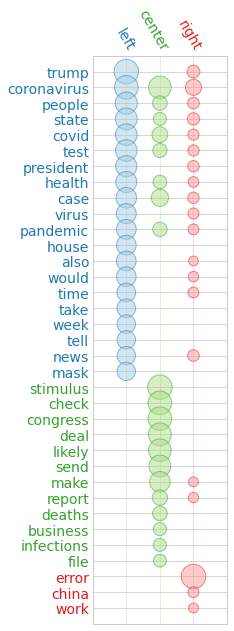

In [90]:
draw_termite_plot(np.array(df_norm.values),df_top20_words.columns,df_top20_words.index,highlight_cols=[0,1,2])

**Topic by target**

In [113]:
data['dominant_topic'] = pd.Series(dominant_topics)

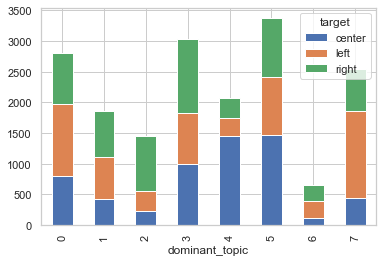

In [122]:
data.groupby(by=['dominant_topic','target']).count()['source'].unstack().plot(kind='bar',stacked=True)

**Polarity by target**

In [98]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

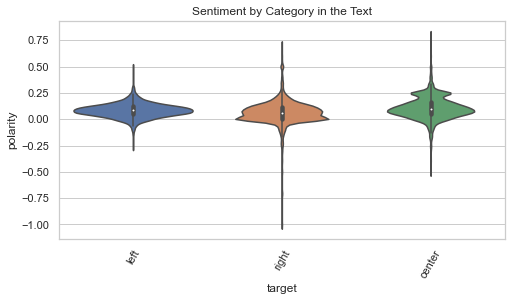

In [102]:
plt.figure(figsize=(8,4))
ax = sns.violinplot(x="target", y="polarity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

**Polarity over time**

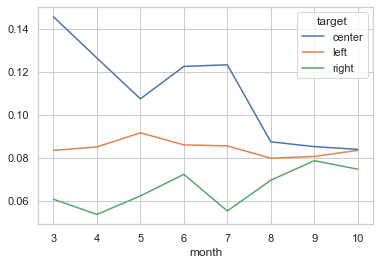

In [123]:
data.groupby(by=['month','target'])['polarity'].mean().unstack().plot()

**Subjectivity by target**

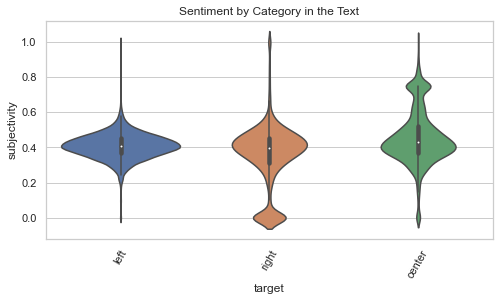

In [104]:
plt.figure(figsize=(8,4))
ax = sns.violinplot(x="target", y="subjectivity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

**Subjectivity over time**

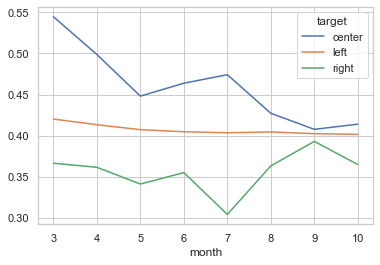

In [124]:
data.groupby(by=['month','target'])['subjectivity'].mean().unstack().plot()

**n_long_words by target**

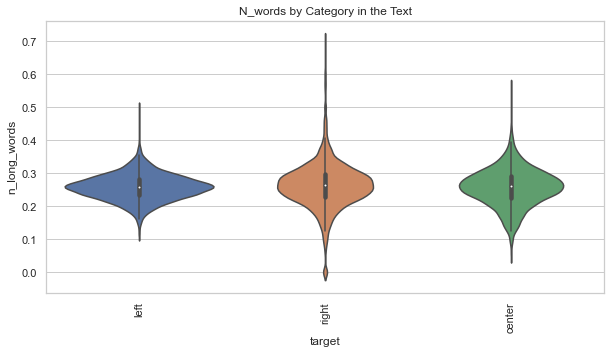

In [125]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_long_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**n_monosyllable_words by target**

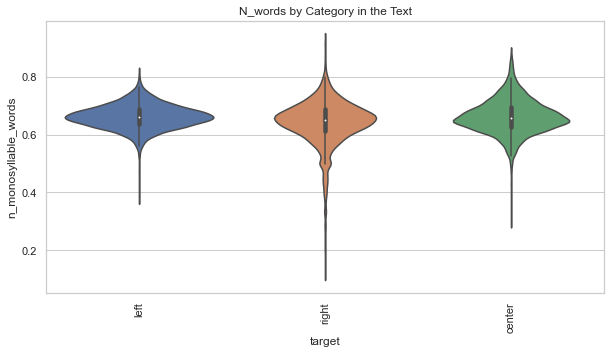

In [126]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_monosyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**n_polysyllable_words by target**

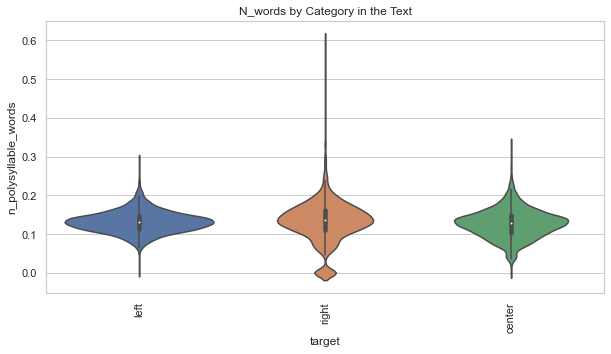

In [127]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_polysyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**n_unique_words by target**

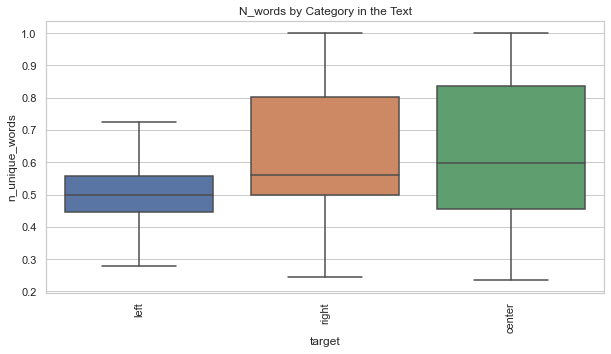

In [132]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_unique_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [131]:
data[data['n_unique_words']>.95]

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,Stats,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,dominant_topic
1004,nbc-news,NBCNews.com,Watch live: New York Gov. Andrew Cuomo holds b...,https://www.nbcnews.com/video/watch-live-new-y...,2020-06-02 15:36:02+00:00,<ol><li>Watch live: New York Gov. Andrew Cuomo...,left,6.0,"Protesters in Minneapolis take knee, chant nam...",video/watch-live-new-york-gov-andrew-cuomo-hol...,Watch live: New York Gov. Andrew Cuomo holds b...,"{'n_chars': 162, 'n_long_words': 6, 'n_monosyl...",0.193548,0.709677,0.129032,0.967742,0.136364,0.477273,0,0,0,0,0,0,0,1,7
1981,nbc-news,NBCNews.com,European countries ease coronavirus lockdown m...,https://www.nbcnews.com/nightly-news/video/eur...,2020-05-11 22:55:09+00:00,The U.K. government encouraged people to go ba...,left,5.0,"Protesters in Minneapolis take knee, chant nam...",nightly-news/video/european-countries-ease-cor...,European countries ease coronavirus lockdown m...,"{'n_chars': 123, 'n_long_words': 7, 'n_monosyl...",0.318182,0.590909,0.181818,0.954545,0.000000,0.000000,1,0,0,0,0,0,0,0,0
2054,independent,Via AP news wire,Israel tightens second lockdown as virus cases...,https://www.independent.co.uk/news/israel-tigh...,2020-09-24 08:06:58+00:00,Israel on Thursday moved to further tighten it...,left,9.0,401 Error,k/news/israel-tightens-second-lockdown-virus-c...,Israel tightens second lockdown as virus cases...,"{'n_chars': 52, 'n_long_words': 2, 'n_monosyll...",0.200000,0.400000,0.000000,1.000000,0.000000,0.000000,0,0,0,0,0,1,0,0,5
2237,independent,Graeme Massie,Bill Gates says Donald Trump’s travel bans wor...,https://www.independent.co.uk/news/world/ameri...,2020-09-18 21:37:21+00:00,Bill Gates says that Donald Trumps travel bans...,left,9.0,401 Error,k/news/world/americas/bill-gates-donald-trump-...,Bill Gates says Donald Trump’s travel bans wor...,"{'n_chars': 71, 'n_long_words': 3, 'n_monosyll...",0.230769,0.538462,0.153846,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,1,7
2295,independent,Via AP news wire,"India's coronavirus cases cross 8 million, beh...",https://www.independent.co.uk/news/indias-coro...,2020-10-29 04:03:27+00:00,Indias confirmed coronavirus toll has crossed ...,left,10.0,401 Error,k/news/indias-coronavirus-cases-cross-8-millio...,"India's coronavirus cases cross 8 million, beh...","{'n_chars': 52, 'n_long_words': 2, 'n_monosyll...",0.181818,0.454545,0.090909,1.000000,-0.200000,0.350000,0,0,0,0,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17725,fortune,Danielle Abril,"Gig workers petition Uber, Lyft, DoorDash and ...",https://fortune.com/2020/03/10/gig-workers-pet...,2020-03-10 23:43:58+00:00,"Gig workers for outfits like Uber, Lyft, DoorD...",center,3.0,When Congress is likely to make a deal to send...,2020/03/10/gig-workers-petition-for-sick-leave...,"Gig workers petition Uber, Lyft, DoorDash and ...","{'n_chars': 130, 'n_long_words': 7, 'n_monosyl...",0.259259,0.703704,0.148148,0.962963,-0.071429,0.785714,0,0,0,0,1,0,0,0,4
17755,fortune,Bernhard Warner,"With food tourism in crisis, virtual pasta and...",https://fortune.com/2020/07/18/food-tourism-co...,2020-07-18 12:00:00+00:00,Traveling Spoon used to connect travelers to l...,center,7.0,When Congress is likely to make a deal to send...,2020/07/18/food-tourism-covid-virtual-cooking-...,"With food tourism in crisis, virtual pasta and...","{'n_chars': 113, 'n_long_words': 5, 'n_monosyl...",0.200000,0.680000,0.080000,0.960000,0.250000,0.750000,0,0,0,0,1,0,0,0,4
17765,fortune,"Michal Lev-Ram, writer",Here’s why Zoom was zooming even before the co...,https://fortune.com/2020/03/18/zoom-is-zooming...,2020-03-18 19:00:00+00:00,Demand for the videoconferencing app has boome...,center,3.0,When Congress is likely to make a deal to send...,2020/03/18/zoom-